In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [129]:
df1 = gpd.read_file("https://parisdata.opendatasoft.com/explore/dataset/comptage-velo-compteurs/download/?format=geojson&timezone=Europe/Berlin&lang=fr")

In [130]:
df1 = df1.drop(['url_photos_n1', 'name', 'id', 'channel_id', 'installation_date', 'nom_compteur', 'channel_name'], axis =1)

In [131]:
df1.rename(columns={'id_compteur': 'Identifiant du compteur'}, inplace=True)

faire un join sur id compteur avec la geometry

In [132]:
df = pd.read_csv("https://raw.githubusercontent.com/linogaliana/python-datascientist/master/data/bike.csv", compression = "gzip")

In [133]:
df = df.merge(df1, how = 'left')

In [134]:
len(df['Identifiant du compteur'].unique())

95

In [135]:
len(df['geometry'].unique())

67

In [136]:
df[df['geometry']==None].groupby('Identifiant du compteur').count()

,Nom du compteur,Identifiant du site de comptage,Nom du site de comptage,Comptage horaire,Date et heure de comptage,Date d'installation du site de comptage,geometry
Identifiant du compteur,,,,,,,
100003096-SC,10052,10052,10052,10052,10052,10052,0
100003099-SC,10053,10053,10053,10053,10053,10053,0


On a au moins 2 compteurs qui n'ont pas de geometry associée. Pas vraiment ok avec la différence entre les uniques geom et les uniques id. A vérifier.

**Cartes des points de comptage**

Problèmes avec les points de comptage, il faudrait bien regarder pourquoi ça s'affiche pas sur la carte, et essayer avec folium. A faire à partir du mercredi 9/12.

In [156]:
departements = gpd.read_file('https://www.data.gouv.fr/fr/datasets/r/ec305e78-f231-4a77-b32c-1e0c4c67615e')

In [157]:
dpt = departements[departements['code_departement'].isin(['75', '77', '78', '91', '92', '93', '94', '95' ])]

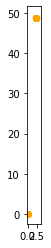

In [162]:
fig, ax = plt.subplots()
dpt.plot(ax=ax, color = 'white', edgecolor = 'black', alpha = 0.1)
df1.plot(ax=ax, color = 'orange')
plt.show()

**Exemple avec le compteur 100003096-SC**

In [4]:
denfert = df[df['Identifiant du compteur'].isin(['100003096-SC'])]

In [5]:
denfert['deltah'] = denfert['Date et heure de comptage'].str[11:13]
denfert['deltaj'] = denfert['Date et heure de comptage'].str[:10]

<ipython-input-5-295005bd9084>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  denfert['deltah'] = denfert['Date et heure de comptage'].str[11:13]
<ipython-input-5-295005bd9084>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  denfert['deltaj'] = denfert['Date et heure de comptage'].str[:10]


In [6]:
denfert['date'] = pd.to_datetime(denfert['Date et heure de comptage'])

<ipython-input-6-fff6e37af85c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  denfert['date'] = pd.to_datetime(denfert['Date et heure de comptage'])


In [7]:
denfert = denfert.sort_values('date')

In [8]:
denfert.head(5)

,Identifiant du compteur,Nom du compteur,Identifiant du site de comptage,Nom du site de comptage,Comptage horaire,Date et heure de comptage,Date d'installation du site de comptage,deltah,deltaj,date
1,100003096-SC,97 avenue Denfert Rochereau SO-NE,100003096,97 avenue Denfert Rochereau SO-NE,0,2019-08-01T01:00:00Z,2012-02-22,01,2019-08-01,2019-08-01 01:00:00+00:00
0,100003096-SC,97 avenue Denfert Rochereau SO-NE,100003096,97 avenue Denfert Rochereau SO-NE,1,2019-08-01T02:00:00Z,2012-02-22,02,2019-08-01,2019-08-01 02:00:00+00:00
3,100003096-SC,97 avenue Denfert Rochereau SO-NE,100003096,97 avenue Denfert Rochereau SO-NE,0,2019-08-01T03:00:00Z,2012-02-22,03,2019-08-01,2019-08-01 03:00:00+00:00
2,100003096-SC,97 avenue Denfert Rochereau SO-NE,100003096,97 avenue Denfert Rochereau SO-NE,0,2019-08-01T04:00:00Z,2012-02-22,04,2019-08-01,2019-08-01 04:00:00+00:00
5,100003096-SC,97 avenue Denfert Rochereau SO-NE,100003096,97 avenue Denfert Rochereau SO-NE,6,2019-08-01T05:00:00Z,2012-02-22,05,2019-08-01,2019-08-01 05:00:00+00:00


In [ ]:
plt.plot(denfert['Date et heure de comptage'], denfert['Comptage horaire'])

In [23]:
import datetime 
denfert['day'] = denfert.date.dt.day_name()
denfert['month'] = denfert.date.dt.month

In [25]:
#moyenne des comptages chaque heure par jour 
moyenne_journee = denfert[['Comptage horaire', 'deltaj', 'day']].groupby('day').mean()

,Comptage horaire
day,
Friday,17.293056
Monday,15.291667
Saturday,17.167361
Sunday,14.641418
Thursday,17.100764
Tuesday,17.050070
Wednesday,16.552260


<BarContainer object of 7 artists>

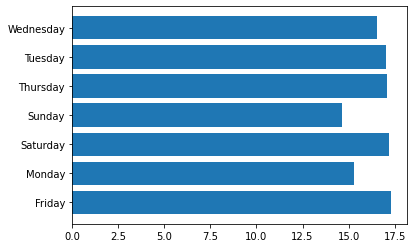

In [26]:
plt.barh(moyenne_journee.index, moyenne_journee['Comptage horaire'])

<BarContainer object of 12 artists>

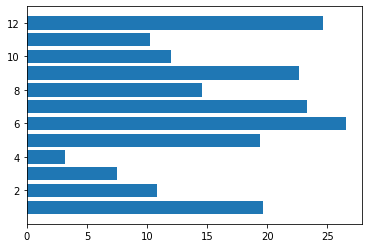

In [27]:
#moyenne des comptages chaque heure par mois
moyenne_mensuelle = denfert[['Comptage horaire', 'deltaj', 'day', 'month']].groupby('month').mean()
plt.barh(moyenne_mensuelle.index,moyenne_mensuelle['Comptage horaire'])

<BarContainer object of 24 artists>

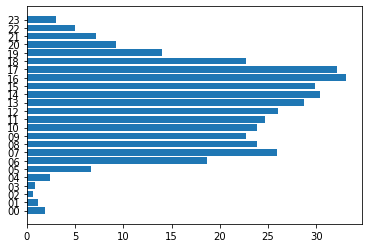

In [28]:
#moyenne des comptages par heure
moyenne_horaire = denfert[['Comptage horaire', 'deltaj', 'day', 'month', 'deltah']].groupby('deltah').mean()
plt.barh(moyenne_horaire.index,moyenne_horaire['Comptage horaire'])

Text(0.5, 1.0, 'Moyenne des comptages horaires pour chaque jour')

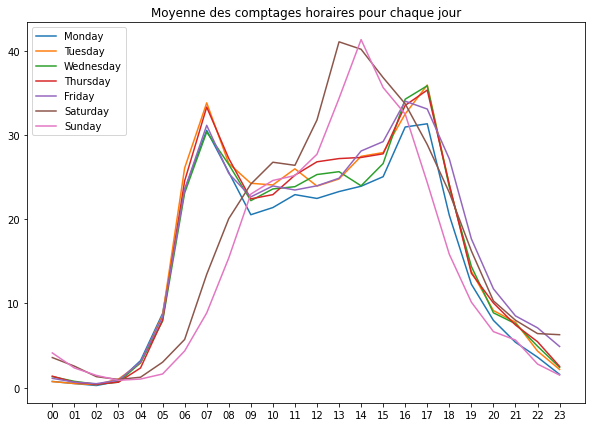

In [29]:
#moyenne des comptages horaires par jour de la semaine
a = denfert[['Comptage horaire', 'deltaj', 'day', 'deltah']].groupby(['day', 'deltah']).mean()
fig, ax = plt.subplots(figsize =(10,7))
ax.plot(a.loc['Monday'], label = 'Monday')
ax.plot(a.loc['Tuesday'], label = 'Tuesday')
ax.plot(a.loc['Wednesday'], label = 'Wednesday')
ax.plot(a.loc['Thursday'], label = 'Thursday')
ax.plot(a.loc['Friday'], label = 'Friday')
ax.plot(a.loc['Saturday'], label = 'Saturday')
ax.plot(a.loc['Sunday'], label = 'Sunday')
ax.legend(loc = 'upper left')
plt.title('Moyenne des comptages horaires pour chaque jour')

In [65]:
a

Comptage horaire
day       deltah                  
Friday    00              1.100000
          01              0.650000
          02              0.466667
          03              0.883333
          04              3.050000
...                            ...
Wednesday 19             14.389831
          20              8.881356
          21              7.593220
          22              4.915254
          23              2.406780

[168 rows x 1 columns]

On voit que tous les jours se ressemblent sauf les week-end : on peut donc traiter d'un côté les jours de la semaine et de l'autre le week-end. 

**On essaye d'avoir ce plot pour tous les compteurs**

On se restreint aux variations sur la semaine. On considère que tous les mois sont pareils pour une première approche. Idée qu'un GPS ne fait pas forcément la différence entre août et septembre en terme de flux de cyclistes. 

In [137]:
df['deltah'] = df['Date et heure de comptage'].str[11:13]
df['deltaj'] = df['Date et heure de comptage'].str[:10]

In [138]:
df['date'] = pd.to_datetime(df['Date et heure de comptage'])

In [139]:
df = df.sort_values('date')

In [140]:
df['day'] = df.date.dt.day_name()
df['month'] = df.date.dt.month

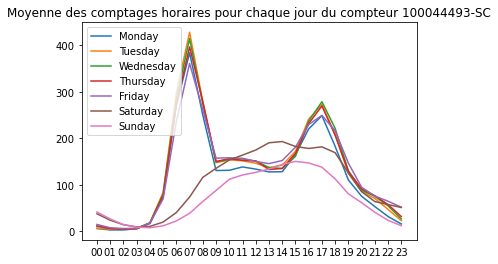

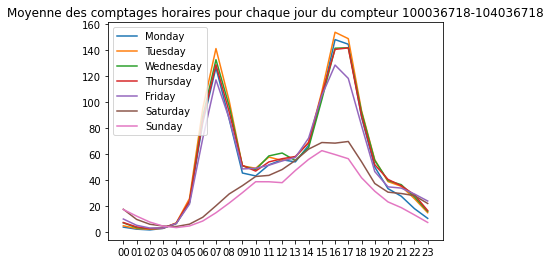

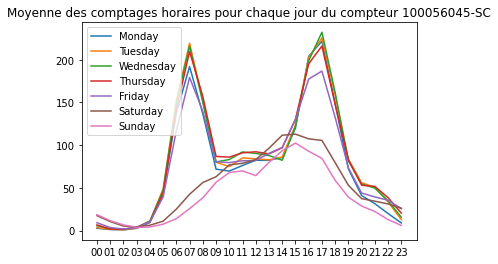

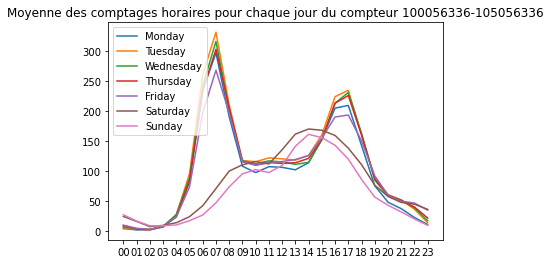

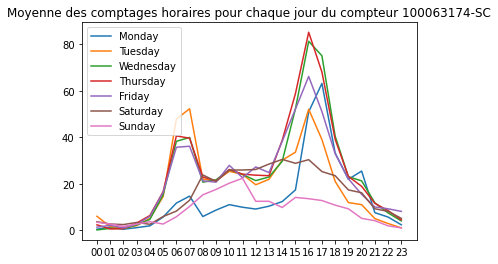

In [141]:
b = df[['Identifiant du compteur','Comptage horaire', 'deltaj', 'day', 'deltah']].groupby(['Identifiant du compteur','day', 'deltah']).mean()
for k in np.random.choice(df['Identifiant du compteur'].unique(), 5):
    c = b.loc[k]
    fig, ax = plt.subplots()
    ax.plot(c.loc['Monday'], label = 'Monday')
    ax.plot(c.loc['Tuesday'], label = 'Tuesday')
    ax.plot(c.loc['Wednesday'], label = 'Wednesday')
    ax.plot(c.loc['Thursday'], label = 'Thursday')
    ax.plot(c.loc['Friday'], label = 'Friday')
    ax.plot(c.loc['Saturday'], label = 'Saturday')
    ax.plot(c.loc['Sunday'], label = 'Sunday')
    ax.legend(loc = 'upper left')
    plt.title(f'Moyenne des comptages horaires pour chaque jour du compteur {k}')


**On construit un indicateur de congestion en fonction des jours de la semaine**

On regarde les valeurs horaires : min, max, moyenne,...

In [142]:
df.sort_values('Comptage horaire', ascending = False)['Comptage horaire'].head(10)

535788    1275
536819    1267
100580    1254
535730    1252
603187    1250
603901    1250
536661    1245
6973      1241
536596    1239
770413    1236
Name: Comptage horaire, dtype: int64

In [143]:
df[df['Comptage horaire']>800].count()

Identifiant du compteur                    363
Nom du compteur                            363
Identifiant du site de comptage            363
Nom du site de comptage                    363
Comptage horaire                           363
Date et heure de comptage                  363
Date d'installation du site de comptage    363
geometry                                   363
deltah                                     363
deltaj                                     363
date                                       363
day                                        363
month                                      363
dtype: int64

In [144]:
b['Comptage horaire'].describe()

count    15960.000000
mean        57.209833
std         67.601512
min          0.000000
25%          8.888889
50%         35.032574
75%         79.592391
max        666.515152
Name: Comptage horaire, dtype: float64

In [145]:
b['Comptage horaire'].quantile(0.99)

317.80116666666663

<AxesSubplot:xlabel='Identifiant du compteur,day,deltah'>

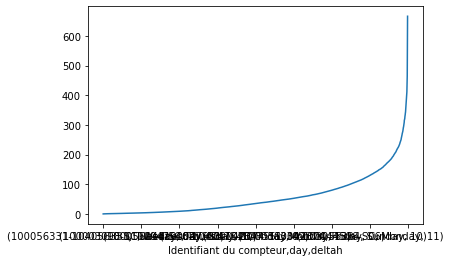

In [146]:
b.sort_values('Comptage horaire')['Comptage horaire'].plot()

In [147]:
conditionlist = [
    (df['Comptage horaire'] >= 720), #congestion 
    ((df['Comptage horaire']>360) & (df['Comptage horaire']<720)), #fluide
    (df['Comptage horaire'] <= 360) #très fluide 
]
choicelist = ['rouge', 'orange','vert']
df['congestion'] = np.select(conditionlist, choicelist, default = 'Not Specified')

In [172]:
df.groupby('congestion').count()

,Identifiant du compteur,Nom du compteur,Identifiant du site de comptage,Nom du site de comptage,Comptage horaire,Date et heure de comptage,Date d'installation du site de comptage,geometry,deltah,deltaj,date,day,month
congestion,,,,,,,,,,,,,
orange,10322,10322,10322,10322,10322,10322,10322,10278,10322,10322,10322,10322,10322
rouge,735,735,735,735,735,735,735,735,735,735,735,735,735
vert,762653,762653,762653,762653,762653,762653,762653,742592,762653,762653,762653,762653,762653


Il faudrait à terme passer ces couleurs en folium : le troçon ou le point de comptage doit s'afficher de la couleur correspondant à l'état de congestion.

**Date et heure**

On crée une fonction capable de trouver la date de l'heure de l'utilisation et de trouver les données correspondantes dans df 

In [149]:
#on trouve le jour de la requête 
import datetime
now = datetime.datetime.now()
jour = []
jour.append(now.strftime("%A"))

In [150]:
#on trouve l'heure de la requête (merci Vinci)
import time
Time = time.strftime('%H:%M', time.localtime()) #Heure uniquement 
heure = []
heure.append(Time[:2])

In [151]:
#La base qui nous intéresse en fonction de l'heure et du jour de la requête 
useful = df[(df['deltah'].isin(heure))&(df['day'].isin(jour))]

In [152]:
useful

,Identifiant du compteur,Nom du compteur,Identifiant du site de comptage,Nom du site de comptage,Comptage horaire,Date et heure de comptage,Date d'installation du site de comptage,geometry,deltah,deltaj,date,day,month,congestion
63046,100044506-SC,72 boulevard Voltaire NO-SE,100044506,72 boulevard Voltaire NO-SE,32,2019-08-06T23:00:00Z,2018-06-27,POINT (2.37407 48.86155),23,2019-08-06,2019-08-06 23:00:00+00:00,Tuesday,8,vert
133323,100047548-103047548,Face au 25 quai de l'Oise NE-SO,100047548,Face au 25 quai de l'Oise,5,2019-08-06T23:00:00Z,2018-11-28,POINT (2.38495 48.89142),23,2019-08-06,2019-08-06 23:00:00+00:00,Tuesday,8,vert
48585,100042374-109042374,Voie Georges Pompidou SO-NE,100042374,Voie Georges Pompidou,3,2019-08-06T23:00:00Z,2017-12-15,POINT (2.27586 48.84840),23,2019-08-06,2019-08-06 23:00:00+00:00,Tuesday,8,vert
95448,100047541-SC,Pont National SO-NE,100047541,Pont National SO-NE,0,2019-08-06T23:00:00Z,2018-12-05,POINT (2.38409 48.82658),23,2019-08-06,2019-08-06 23:00:00+00:00,Tuesday,8,vert
151169,100049407-102049407,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,3,2019-08-06T23:00:00Z,2018-12-07,POINT (2.33323 48.84080),23,2019-08-06,2019-08-06 23:00:00+00:00,Tuesday,8,vert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467693,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1,2020-09-15T23:00:00Z,2013-01-18,POINT (2.37543 48.84603),23,2020-09-15,2020-09-15 23:00:00+00:00,Tuesday,9,vert
607394,100060175-SC,30 rue Saint Jacques N-S,100060175,30 rue Saint Jacques N-S,31,2020-09-15T23:00:00Z,2020-05-20,POINT (2.34568 48.85113),23,2020-09-15,2020-09-15 23:00:00+00:00,Tuesday,9,vert
484765,100044494-SC,10 avenue de la Grande Armée SE-NO,100044494,10 avenue de la Grande Armée SE-NO,12,2020-09-15T23:00:00Z,2018-07-27,POINT (2.29244 48.87472),23,2020-09-15,2020-09-15 23:00:00+00:00,Tuesday,9,vert
583538,100056332-104056332,Pont de Bercy SO-NE,100056332,Pont de Bercy,11,2020-09-15T23:00:00Z,2019-12-11,POINT (2.37587 48.83848),23,2020-09-15,2020-09-15 23:00:00+00:00,Tuesday,9,vert
